In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score,recall_score,balanced_accuracy_score, precision_score,f1_score

In [2]:
df = pd.read_csv('../data/cleaning_data_phase2.csv.zip')

In experimentation with np.random.seed, we found that this did not create reproducible results. Instead, we have explicitly set the random_state to 42 in every portion of our model- this will produce reproducible results. 

### Creating X and y variables

In [3]:
X= df.drop(columns = ['_michd','_state'])
y = df['_michd']

In [4]:
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 42)

### Imputing Null Values and One Hot Encoding 

In [5]:
categorical = X.select_dtypes('object').columns
numerical = X.columns.drop(categorical)

In [6]:
ohe = OneHotEncoder(drop='if_binary', handle_unknown='ignore', sparse=False) 
si_numerical = SimpleImputer(strategy='median')  

In [7]:
ctx = ColumnTransformer(
transformers = [
    ('ohe',ohe,categorical),
    ('si_num',si_numerical,numerical)
])

In [8]:
X_train_ohe_imputed = ctx.fit_transform(X_train)
X_test_ohe_imputed = ctx.transform(X_test)

/Users/markbiernacki/opt/anaconda3/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Random Forest on Imbalanced Data

In [10]:
rf = RandomForestClassifier(random_state = 42)

In [11]:
param_dist = {
    'n_estimators': [100],
    'max_depth': [5],
}

rs = RandomizedSearchCV(estimator = rf, param_distributions = param_dist, cv = 3, scoring = 'balanced_accuracy', n_iter =1)


Using Randomized Search CV as opposed to Gridsearch CV in order to maximize efficiency. 
Using balanced_accuracy as the scoring metric, as this is what we want to optimize (instead of training accuracy). For now I am setting the parameters of max depth to be 5, and n_estimators to be 100. I will experiment with different parameters after checking the model performance on various methods of handling the imbalanced data.

In [12]:
rs.fit(X_train_ohe_imputed,y_train)

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
                   n_iter=1,
                   param_distributions={'max_depth': [5],
                                        'n_estimators': [100]},
                   scoring='balanced_accuracy')

### Creating Evaluation Function

In [13]:
def evaluation(X_test, y_test, preds, model):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    
    b_acc = balanced_accuracy_score(y_test, preds)
    recall = recall_score(y_test, preds, pos_label= 'Yes')
    prec = precision_score(y_test, preds, pos_label= 'Yes')
    f1 = f1_score(y_test, preds, pos_label= 'Yes')

    print(f'balanced_accuracy: {b_acc}')
    print(f'recall: {recall}')
    print(f'precision: {prec}')
    print(f'f1 score: {f1}')

    return {
        'balanced_accuracy': b_acc,
        'recall': recall,
        'precision': prec,
        'f1_score': f1
    }

In [14]:
preds1 = rs.predict(X_test_ohe_imputed)

balanced_accuracy: 0.50034876943379
recall: 0.0007080481472740147
precision: 0.8571428571428571
f1 score: 0.0014149274849663955


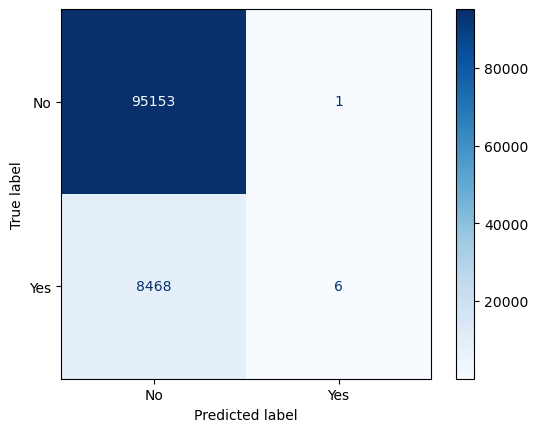

In [15]:
scores = []
scores.append(evaluation(X_test_ohe_imputed,y_test,preds1,rs))

This model performs very poorly. It only predicted 'yes' 7 times total as it heavily favors the majority class.

### Oversample the minority class


In [16]:
pipe_oversample = ImbPipeline(steps = [
    ('sampling',RandomOverSampler(random_state = 42)),
    ('model',rs)
])

In [17]:
pipe_oversample.fit(X_train_ohe_imputed,y_train)

Pipeline(steps=[('sampling', RandomOverSampler(random_state=42)),
                ('model',
                 RandomizedSearchCV(cv=3,
                                    estimator=RandomForestClassifier(random_state=42),
                                    n_iter=1,
                                    param_distributions={'max_depth': [5],
                                                         'n_estimators': [100]},
                                    scoring='balanced_accuracy'))])

In [18]:
preds_oversample = pipe_oversample.predict(X_test_ohe_imputed)

balanced_accuracy: 0.7714427676905642
recall: 0.8292423884824168
precision: 0.205018234865062
f1 score: 0.3287562282158647


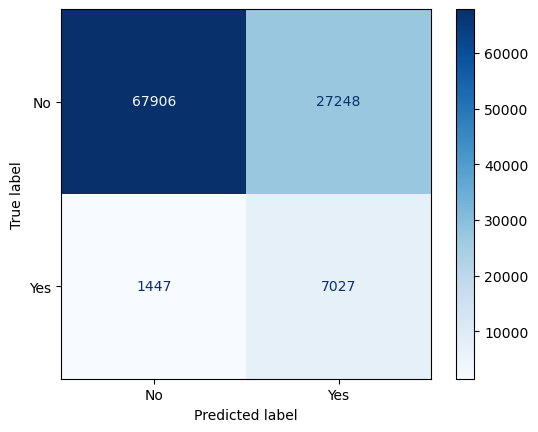

In [19]:
scores.append(evaluation(X_test_ohe_imputed,y_test,preds_oversample,pipe_oversample))

Oversampling the minority class led to significantly higher recall and balanced_accuracy

### SMOTE

In [20]:
pipe_smote = ImbPipeline(steps = [
    ('sampling',SMOTE(random_state = 42)),
    ('model',rs)
])

balanced_accuracy: 0.7028969247416863
recall: 0.5257257493509558
precision: 0.28077141236528647
f1 score: 0.3660490530380839


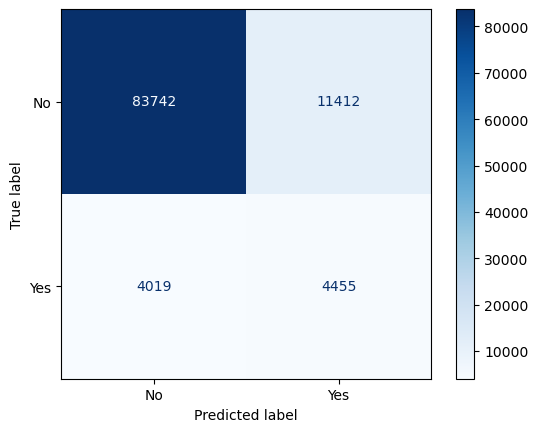

In [21]:
pipe_smote.fit(X_train_ohe_imputed,y_train)
preds_smote = pipe_smote.predict(X_test_ohe_imputed)
scores.append(evaluation(X_test_ohe_imputed,y_test,preds_smote,pipe_smote))

Using Smote to account for the imbalanced data produced worse results than oversampling the minority class

### ADASYN

In [22]:
pipe_adasyn = ImbPipeline(steps = [
    ('sampling',ADASYN(random_state = 42)),
    ('model',rs)
])

balanced_accuracy: 0.7021470899918624
recall: 0.5212414444182204
precision: 0.28414281119330975
f1 score: 0.36779216453640867


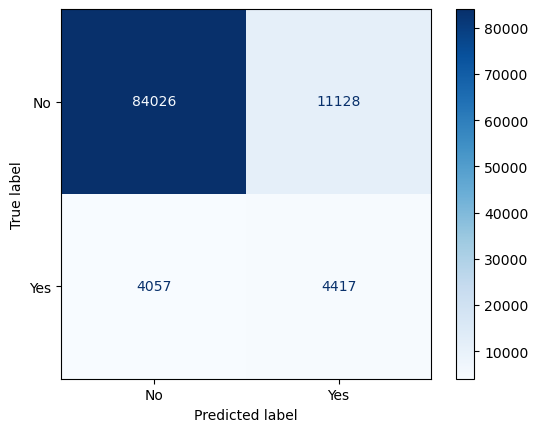

In [23]:
pipe_adasyn.fit(X_train_ohe_imputed,y_train)
preds_adasyn = pipe_adasyn.predict(X_test_ohe_imputed)
scores.append(evaluation(X_test_ohe_imputed,y_test,preds_adasyn,pipe_adasyn))

Using ADASYN yielded worse results than oversampling the minority class.

### Oversample Method with hypertuned parameters
Since this method produced the highest balanced accuracy and recall, we can now try to optimize the model based on several parameters.

In [24]:
param_dist = {
    'sampling__sampling_strategy':[.25,.75],
    'model__n_estimators': [100,200,300],
    'model__max_depth': [5,10,15,20],
}
pipe_oversample_gridsearch= ImbPipeline(steps = [
    ('sampling',RandomOverSampler(random_state = 42)),
    ('model',rf)
])


In [25]:
rs2 = RandomizedSearchCV(estimator = pipe_oversample_gridsearch, param_distributions = param_dist, cv = 3, scoring = 'balanced_accuracy',n_jobs = -1)

In [26]:
rs2.fit(X_train_ohe_imputed,y_train)

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('sampling',
                                              RandomOverSampler(random_state=42)),
                                             ('model',
                                              RandomForestClassifier(random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth': [5, 10, 15, 20],
                                        'model__n_estimators': [100, 200, 300],
                                        'sampling__sampling_strategy': [0.25,
                                                                        0.75]},
                   scoring='balanced_accuracy')

In [27]:
oversample_gridsearch_preds= rs2.predict(X_test_ohe_imputed)

balanced_accuracy: 0.7772295275647443
recall: 0.7675241916450318
precision: 0.24288595115393233
f1 score: 0.36900034040621804


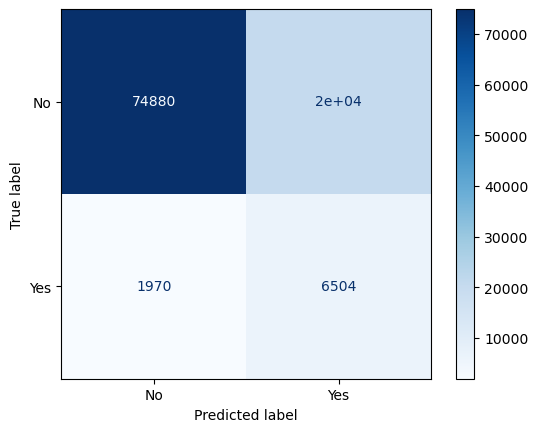

In [28]:
scores.append(evaluation(X_test_ohe_imputed,y_test,oversample_gridsearch_preds,rs2))

This model slightly improved the balanced_accuracy but drastically reduced the recall. 
The Oversampling without hypertuned parameters performed the best on the average of recall and balanced accuracy. 

In [29]:
scores

[{'balanced_accuracy': 0.50034876943379,
  'recall': 0.0007080481472740147,
  'precision': 0.8571428571428571,
  'f1_score': 0.0014149274849663955},
 {'balanced_accuracy': 0.7714427676905642,
  'recall': 0.8292423884824168,
  'precision': 0.205018234865062,
  'f1_score': 0.3287562282158647},
 {'balanced_accuracy': 0.7028969247416863,
  'recall': 0.5257257493509558,
  'precision': 0.28077141236528647,
  'f1_score': 0.3660490530380839},
 {'balanced_accuracy': 0.7021470899918624,
  'recall': 0.5212414444182204,
  'precision': 0.28414281119330975,
  'f1_score': 0.36779216453640867},
 {'balanced_accuracy': 0.7772295275647443,
  'recall': 0.7675241916450318,
  'precision': 0.24288595115393233,
  'f1_score': 0.36900034040621804}]

In [30]:
evaluations = pd.DataFrame(scores, index = ['imbalanced data','oversampling','SMOTE','ADASYN','Hypertuned Oversampling'])

In [31]:
evaluations.to_csv('../data/scores_RandomForest.csv')

### Inference
Producing Probabilities that an individual has heart disease using the best model (RF with oversampling). This is an example imlementation that could be used by healthcare professionals.

In [32]:
test_proba = pipe_oversample.predict_proba(X_test_ohe_imputed)

In [33]:
test_proba

array([[0.95588924, 0.04411076],
       [0.79289085, 0.20710915],
       [0.49550716, 0.50449284],
       ...,
       [0.9630898 , 0.0369102 ],
       [0.73400355, 0.26599645],
       [0.94147973, 0.05852027]])

Getting the most important features from the random forest model

In [34]:
rf_model = pipe_oversample.named_steps['model'].best_estimator_

feature_importances = rf_model.feature_importances_

In [35]:
feature_importances.shape

(151,)

In [36]:
importance_dict = dict(zip(ctx.get_feature_names_out(), feature_importances))


In [37]:
sorted_importance_dict = dict(sorted(importance_dict.items(), key = lambda item: item[1], reverse = True))

In [38]:
top5_list = list(sorted_importance_dict.items())[:5]

In [39]:
top5_df = pd.DataFrame(top5_list,columns = ['Feature','Importance'])

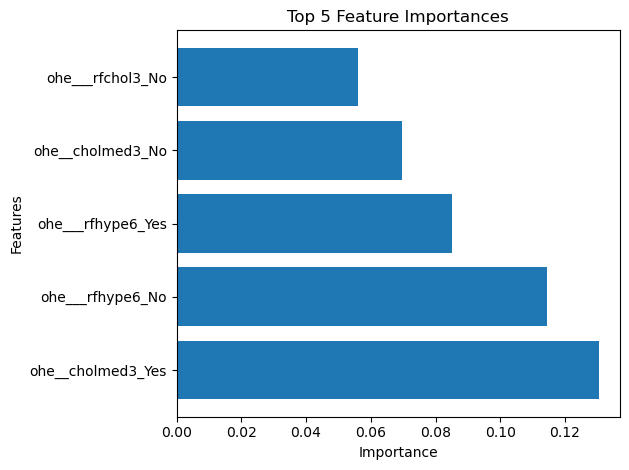

In [40]:
plt.figure()
plt.barh(top5_df['Feature'],top5_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 5 Feature Importances')
plt.tight_layout()
plt.savefig('../graph/top_5_feature_importances.png')

This graph shows the five most important features according to the random forest model with oversampling. We can see that taking cholestoral medicine (or not), having been told that you have high blood pressure (or not) and age are the most important features in the model.